# Part II Project Notebook

## NMA Exploration in ProDy

In [1]:
%pip install prody
%pip install matplotlib.pylab


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pylab (from versions: none)
ERROR: No matching distribution found for matplotlib.pylab


### Parse Structure

In [5]:
from prody import *

from matplotlib.pylab import *

ion()

C:\Users\Mihailo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [6]:
ubi = parsePDB('1aar')

ubi

@> PDB file is found in working directory (1aar.pdb).
@> 1218 atoms and 1 coordinate set(s) were parsed in 0.04s.


<AtomGroup: 1aar (1218 atoms)>

In [7]:
calphas = ubi.select('calpha and chain A and resnum < 71')

calphas

<Selection: 'calpha and chai...and resnum < 71' from 1aar (70 atoms)>

In [5]:
gnm = GNM(name = 'Ubiquintin')

### Build Kirchhoff matrix

In [6]:
gnm.buildKirchhoff(coords=calphas, cutoff=10.0, gamma=1.0)

@> Kirchhoff was built in 0.00s.


In [7]:
gnm.getKirchhoff()

array([[11., -1., -1., ...,  0.,  0.,  0.],
       [-1., 15., -1., ...,  0.,  0.,  0.],
       [-1., -1., 20., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 20., -1., -1.],
       [ 0.,  0.,  0., ..., -1., 21., -1.],
       [ 0.,  0.,  0., ..., -1., -1., 12.]])

### Parameters

In [8]:
gnm.getCutoff()

10.0

In [9]:
gnm.getGamma()

1.0

### Calculate Normal Modes

In [10]:
gnm.calcModes(20, zeros=False)

@> 20 modes were calculated in 0.02s.


### Normal Mode Data

In [11]:
gnm.getEigvals().round(3)

array([ 2.502,  2.812,  4.366,  5.05 ,  7.184,  7.65 ,  7.877,  9.08 ,
        9.713, 10.132, 10.502, 10.644, 10.888, 11.157, 11.285, 11.632,
       11.78 , 11.936, 12.006, 12.218])

In [12]:
gnm.getEigvecs().round(3)

array([[-0.064, -0.131, -0.245, ..., -0.256,  0.538, -0.   ],
       [-0.073, -0.085, -0.19 , ...,  0.006, -0.069,  0.032],
       [-0.076, -0.043, -0.135, ...,  0.017, -0.047,  0.018],
       ...,
       [-0.092,  0.064,  0.105, ...,  0.032, -0.042,  0.006],
       [-0.07 ,  0.099,  0.054, ...,  0.031,  0.024, -0.014],
       [-0.081,  0.135,  0.124, ...,  0.013, -0.04 , -0.018]])

### NMA on CPU using GNM Function

In [13]:
def calculate_modes_gnm_cpu(protein_name, cutoff = 7.0, num_modes=20, gamma = 1):
    """
    Function to calculate normal modes on CPU

    Arguments:  
        protein_name : string - PDB id of a protein
        cutoff : double - cutoff distance for GNM algorithm
        num_modes : integer - number of lowest non-trivial modes calculated
        gamma : double - constant for potential energy calculation
    Outputs:
        (eigenvals, eigenvecs) : (array(double), array(array(double))) - calculated modes and eigenvalues 
    """
    protein = parsePDB(protein_name)
    calphas = protein.select('calpha')

    gnm = GNM()
    gnm.buildKirchhoff(coords=calphas, cutoff=cutoff, gamma=gamma)

    gnm.calcModes(num_modes, zeros=False)
    return (gnm.getEigvals(), gnm.getEigvecs())

In [14]:
calculate_modes_gnm_cpu(protein_name = '1aar', cutoff = 7.0, num_modes = 20, gamma = 1.0)

@> PDB file is found in working directory (1aar.pdb.gz).
@> 1218 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Kirchhoff was built in 0.01s.
@> 20 modes were calculated in 0.04s.


(array([0.14151754, 0.38104426, 0.46836206, 0.49593759, 0.58382043,
        0.74431723, 0.99646697, 1.28180999, 1.56646564, 1.67868394,
        1.95557404, 2.0090235 , 2.03833678, 2.22876991, 2.36152138,
        2.5340486 , 2.7414319 , 2.82949063, 3.48699585, 3.54410935]),
 array([[ 1.03374384e-01, -9.82880493e-03,  9.08562012e-02, ...,
          8.70083494e-03, -2.02469425e-02,  6.72316938e-02],
        [ 9.30774820e-02, -3.26144808e-03,  1.15694755e-01, ...,
         -5.83068367e-02,  3.15810145e-02, -7.94458795e-02],
        [ 8.71730373e-02, -5.12303779e-04,  1.16869498e-01, ...,
         -6.31150849e-02,  1.62240898e-02, -4.83183478e-02],
        ...,
        [-3.87764509e-02,  2.74922729e-01, -2.03643722e-02, ...,
         -6.47737074e-02, -1.81914991e-03,  9.33410435e-03],
        [-4.38281298e-02,  4.51078770e-01, -4.61927640e-02, ...,
         -6.18272501e-02, -2.15825057e-02,  5.86602243e-02],
        [-5.10530291e-02,  7.28773875e-01, -8.68876360e-02, ...,
          3.379478

### NMA on CPU using ANM Function

In [15]:
def calculate_modes_anm_cpu(protein_name, cutoff = 7.0, num_modes=20, gamma = 1):
    """
    Function to calculate normal modes on CPU

    Arguments:  
        protein_name : string - PDB id of a protein
        cutoff : double - cutoff distance for GNM algorithm
        num_modes : integer - number of lowest non-trivial modes calculated
        gamma : double - constant for potential energy calculation
    Outputs:
        (eigenvals, eigenvecs) : (array(double), array(array(double))) - calculated modes and eigenvalues 
    """
    protein = parsePDB(protein_name)
    calphas = protein.select('calpha')

    anm = ANM()
    anm.buildHessian(coords=calphas, cutoff=cutoff, gamma=gamma)

    anm.calcModes(num_modes, zeros=False)
    return (anm.getEigvals(), anm.getEigvecs())

In [16]:
calculate_modes_anm_cpu(protein_name = '1aar', cutoff = 7.0, num_modes = 20, gamma = 1.0)

@> PDB file is found in working directory (1aar.pdb.gz).
@> 1218 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> Hessian was built in 0.02s.
@> WARNING More than 6 (10) zero eigenvalues were calculated.
@> Solving for additional eigenvalues...
@> 20 modes were calculated in 0.27s.


(array([0.0017942 , 0.00300006, 0.00326869, 0.00360493, 0.00454109,
        0.00492944, 0.00664014, 0.0084666 , 0.01088321, 0.01172248,
        0.01297695, 0.01378273, 0.01509764, 0.01721543, 0.02058993,
        0.02542463, 0.02643672, 0.02694707, 0.02960575, 0.03364039]),
 array([[-6.54433343e-02, -9.30086589e-02, -2.51089450e-02, ...,
         -5.42175871e-02,  6.05319190e-02, -4.20373223e-02],
        [-4.07659821e-02, -5.58569414e-02, -6.05755436e-02, ...,
         -2.92361728e-02,  2.20959283e-02,  3.91366217e-02],
        [ 1.19016883e-02,  6.49503151e-03,  4.29543346e-02, ...,
         -5.15058144e-02, -2.73614983e-02,  1.43220817e-02],
        ...,
        [ 5.95375806e-03,  4.61585294e-02,  2.52558110e-02, ...,
          3.54890740e-02, -4.68533288e-02,  3.35423351e-02],
        [ 4.40669378e-04,  3.41643887e-03,  1.86931723e-03, ...,
          2.62673559e-03, -3.46786467e-03,  2.48264706e-03],
        [ 9.60029717e-05,  7.44295610e-04,  4.07244111e-04, ...,
          5.722531

## NMA Exploration in Springcraft

In [17]:
%pip install springcraft
%pip install matplotlib.pylab


     ---------------------------------------- 46.9/46.9 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 30.9/30.9 MB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 42.9 MB/s eta 0:00:00
     ---------------------------------------- 62.5/62.5 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement matplotlib.pylab (from versions: none)
ERROR: No matching distribution found for matplotlib.pylab


### Usage

In [5]:
import biotite.structure.io as strucio
import springcraft

# All pairs of atoms within a cutoff distance obtain the same force constant
ff = springcraft.InvariantForceField(cutoff_distance=13.0)

# The force constant is inversely proportional to the squared distance
ff = springcraft.ParameterFreeForceField()

# The force constant is read from tabulated values
# based on residue types and distance
# For the residue type the underlying CA-trace is required
atoms = strucio.load_structure("1aar.pdb")
atoms = atoms[(atoms.atom_name == "CA") & (atoms.element == "C")]
ff = springcraft.TabulatedForceField.sd_enm(atoms)

In [6]:
atoms

array([
	Atom(np.array([14.6  , 29.031, 15.11 ], dtype=float32), chain_id="A", res_id=1, ins_code="", res_name="MET", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([15.552, 25.806, 16.852], dtype=float32), chain_id="A", res_id=2, ins_code="", res_name="GLN", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([15.593, 22.437, 15.13 ], dtype=float32), chain_id="A", res_id=3, ins_code="", res_name="ILE", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([16.773, 19.057, 16.52 ], dtype=float32), chain_id="A", res_id=4, ins_code="", res_name="PHE", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([18.917, 16.876, 14.225], dtype=float32), chain_id="A", res_id=5, ins_code="", res_name="VAL", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([18.713, 13.283, 15.533], dtype=float32), chain_id="A", res_id=6, ins_code="", res_name="LYS", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([21.128, 10.538, 14.58 ], dtype=float32), chain_id="A

In [8]:
ff = springcraft.InvariantForceField(cutoff_distance=13.0)
hessian, pairs = springcraft.compute_hessian(atoms.coord, ff)

In [9]:
hessian

array([[ 5.19572309, -0.34421606, -0.0350209 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.34421606,  8.76178573,  0.51959594, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0350209 ,  0.51959594,  7.04249102, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  3.52643149,
        -0.73890825,  1.49009654],
       [ 0.        ,  0.        ,  0.        , ..., -0.73890825,
         0.53402977, -0.55103007],
       [ 0.        ,  0.        ,  0.        , ...,  1.49009654,
        -0.55103007,  0.93953867]])

In [10]:
pairs

array([[  0,   1],
       [  0,   2],
       [  0,   3],
       ...,
       [151, 148],
       [151, 149],
       [151, 150]], dtype=int64)

In [11]:
gnm = springcraft.GNM(atoms, ff)
eigen_values, eigen_vectors = gnm.eigen()

In [12]:
eigen_values

array([-1.21665267e-15,  2.84135732e+00,  4.29765108e+00,  8.35940261e+00,
        9.48532265e+00,  1.05240745e+01,  1.17240771e+01,  1.21365245e+01,
        1.28147766e+01,  1.41107873e+01,  1.51027112e+01,  1.55277972e+01,
        1.69308823e+01,  1.70848687e+01,  1.80506771e+01,  1.82877559e+01,
        1.86935126e+01,  1.91675102e+01,  1.97725436e+01,  1.99266013e+01,
        2.02584425e+01,  2.08339435e+01,  2.10163595e+01,  2.11699105e+01,
        2.15389438e+01,  2.18151891e+01,  2.19239768e+01,  2.20965495e+01,
        2.23183128e+01,  2.26563713e+01,  2.30817631e+01,  2.33308151e+01,
        2.37202350e+01,  2.37856658e+01,  2.39922518e+01,  2.41018928e+01,
        2.43523524e+01,  2.44587724e+01,  2.47671547e+01,  2.48917813e+01,
        2.51114926e+01,  2.52159804e+01,  2.55650902e+01,  2.56368734e+01,
        2.57771421e+01,  2.58632052e+01,  2.59859429e+01,  2.60447189e+01,
        2.62336962e+01,  2.63392437e+01,  2.65287343e+01,  2.65512311e+01,
        2.65665197e+01,  

In [13]:
eigen_vectors

array([[-8.11107106e-02, -8.11107106e-02, -8.11107106e-02, ...,
        -8.11107106e-02, -8.11107106e-02, -8.11107106e-02],
       [ 1.21579490e-01,  1.13061128e-01,  1.00338032e-01, ...,
        -1.47319652e-02, -5.02380064e-02, -6.55098749e-02],
       [-5.58565407e-03, -6.21635692e-03, -5.01464548e-03, ...,
         1.45423125e-01,  2.89936088e-01,  9.16666433e-01],
       ...,
       [ 4.53167774e-03,  9.31559255e-03, -2.96534888e-02, ...,
         4.16222408e-04, -2.00597487e-03, -1.03933251e-03],
       [-2.36460869e-03, -4.87282985e-03,  1.74470782e-02, ...,
        -4.42041372e-04,  2.48245490e-04, -1.79913304e-04],
       [ 2.69641539e-03,  4.78988867e-03, -2.18683537e-02, ...,
         5.92624616e-03,  2.73246538e-03,  7.11662242e-04]])

In [14]:
import numpy as np

anm = springcraft.ANM(atoms, ff)
force_vector = np.zeros((atoms.array_length(), 3))
force_vector[42, 0] = 10
displacements = anm.linear_response(force_vector)

### Springcraft Example

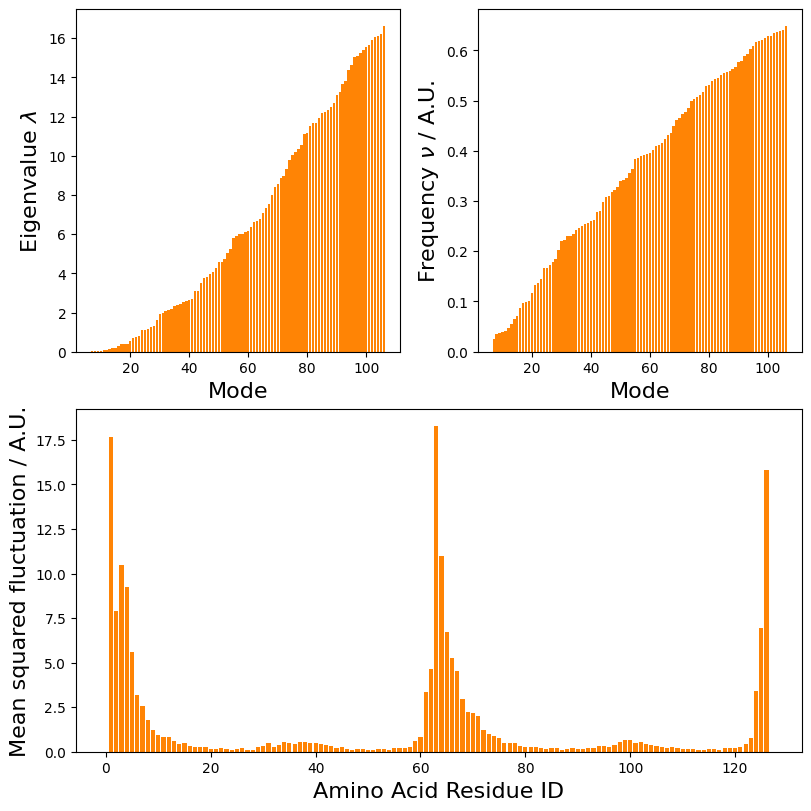

In [2]:
# Code source: Jan Krumbach
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import biotite
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.database.rcsb as rcsb
import springcraft


# Fetch G:T/U Mismatch-specific DNA glycosylase from E. coli
PDB_ID = "1A0A"
mmtf_file = mmtf.MMTFFile.read(rcsb.fetch(PDB_ID, "mmtf"))
whole_structure = mmtf.get_structure(mmtf_file, model=1, include_bonds=True)
protein = whole_structure[struc.filter_amino_acids(whole_structure)]
ca = protein[(protein.atom_name == "CA") & (protein.element == "C")]

# Select forcefield; create ANM object using the eANM forcefield
ff = springcraft.TabulatedForceField.e_anm(ca)
eanm = springcraft.ANM(ca, ff)

## NMA
# Compute eigenvalues and eigenvectors.
# The first 6 eigenvals./eigenvecs corresponding to trivial modes are omitted.
# -> analyse modes 7-107
eigenval, eigenvec = eanm.eigen()
eigenval = eigenval[6:106]
# Compute fluctuations for all residues and frequencies for modes 7-107
msqf = eanm.mean_square_fluctuation()
freq = eanm.frequencies()[6:106]

## Plot
fig = plt.figure(figsize=(8.0, 8.0), constrained_layout=True)
grid = fig.add_gridspec(nrows=2, ncols=2)

ax00 = fig.add_subplot(grid[0, 0])
ax01 = fig.add_subplot(grid[0, 1])
ax1 = fig.add_subplot(grid[1, :])

biotite_c = biotite.colors["orange"]

ax00.bar(x=np.arange(7, len(eigenval)+7), height=eigenval, color=biotite_c)
ax01.bar(x=np.arange(7, len(freq)+7), height=freq, color=biotite_c)
ax1.bar(x=np.arange(1, len(msqf)+1), height=msqf, color=biotite_c)

ax00.set_xlabel("Mode", size=16)
ax00.set_ylabel(r"Eigenvalue $\lambda$", size=16)
ax01.set_xlabel("Mode", size=16)
ax01.set_ylabel(r"Frequency $\nu$ / A.U.", size=16)
ax1.set_xlabel("Amino Acid Residue ID", size=16)
ax1.set_ylabel("Mean squared fluctuation / A.U.", size=16)

plt.show()

### Calculation of 3 Flexibility Measures Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import biotite
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.database.rcsb as rcsb
import biotite.structure.io as strucio
import springcraft

def calculate_normal_modes_gnm_from_file(path, cutoff):
    '''
    Function that calculates eigenvalues and eigenvectors of Kirchhoff matrix using GNM method from .pdb file.

    Arguments:
        path : string - Path to .pdb file containing structure we want to explore
        cutoff : double - Angstrom distance under which two CA atoms are represented as connected
    Returns:
        eigenvalues : array(double) - Eigenvalues of Kirchhoff matrix
        eigenvectors : matrix(double) - Eigenvectors of Kirchhoff matrix represented as rows of the matrix returned   
    '''

    # Read .pdb file and filter CA atoms
    whole_structure = strucio.load_structure(path)
    protein = whole_structure[struc.filter_amino_acids(whole_structure)]
    ca = protein[(protein.atom_name == "CA") & (protein.element == "C")]
    
    # Define force field and GNM object
    ff = springcraft.InvariantForceField(cutoff_distance=cutoff)
    gnm = springcraft.GNM(ca, ff)

    # Return model with all pre-processing
    return gnm

def calculate_normal_modes_gnm_from_id(id, cutoff):
    '''
    Function that calculates eigenvalues and eigenvectors of Kirchhoff matrix using GNM method from PDBID of a structure.

    Arguments:
        id : string - PDBID of a structure we want to explore
        cutoff : double - Angstrom distance under which two CA atoms are represented as connected
    Returns:
        eigenvalues : array(double) - Eigenvalues of Kirchhoff matrix
        eigenvectors : matrix(double) - Eigenvectors of Kirchhoff matrix represented as rows of the matrix returned   
    '''

    # Read .pdb file and filter CA atoms
    mmtf_file = mmtf.MMTFFile.read(rcsb.fetch(id, "mmtf"))
    whole_structure = mmtf.get_structure(mmtf_file, model=1, include_bonds=True)
    protein = whole_structure[struc.filter_amino_acids(whole_structure)]
    ca = protein[(protein.atom_name == "CA") & (protein.element == "C")]
    
    # Define force field and GNM object
    ff = springcraft.InvariantForceField(cutoff_distance=cutoff)
    gnm = springcraft.GNM(ca, ff)

    # Return model with all pre-processing
    return gnm    

def calculate_normal_modes_anm_from_file(path, cutoff):
    '''
    Function that calculates eigenvalues and eigenvectors of Kirchhoff matrix using ANM method from .pdb file.

    Arguments:
        path : string - Path to .pdb file containing structure we want to explore
        cutoff : double - Angstrom distance under which two CA atoms are represented as connected
    Returns:
        eigenvalues : array(double) - Eigenvalues of Kirchhoff matrix
        eigenvectors : matrix(double) - Eigenvectors of Kirchhoff matrix represented as rows of the matrix returned   
    '''

    # Read .pdb file and filter CA atoms
    whole_structure = strucio.load_structure(path)
    protein = whole_structure[struc.filter_amino_acids(whole_structure)]
    ca = protein[(protein.atom_name == "CA") & (protein.element == "C")]
    
    # Define force field and GNM object
    ff = springcraft.InvariantForceField(cutoff_distance=cutoff)
    anm = springcraft.ANM(ca, ff)

    # Return model with all pre-processing
    return anm

def calculate_normal_modes_anm_from_id(id, cutoff):
    '''
    Function that calculates eigenvalues and eigenvectors of Kirchhoff matrix using ANM method from PDBID of a structure.

    Arguments:
        id : string - PDBID of a structure we want to explore
        cutoff : double - Angstrom distance under which two CA atoms are represented as connected
    Returns:
        eigenvalues : array(double) - Eigenvalues of Kirchhoff matrix
        eigenvectors : matrix(double) - Eigenvectors of Kirchhoff matrix represented as rows of the matrix returned   
    '''

    # Read .pdb file and filter CA atoms
    mmtf_file = mmtf.MMTFFile.read(rcsb.fetch(id, "mmtf"))
    whole_structure = mmtf.get_structure(mmtf_file, model=1, include_bonds=True)
    protein = whole_structure[struc.filter_amino_acids(whole_structure)]
    ca = protein[(protein.atom_name == "CA") & (protein.element == "C")]
    
    # Define force field and GNM object
    ff = springcraft.InvariantForceField(cutoff_distance=cutoff)
    anm = springcraft.ANM(ca, ff)

    # Return model with all pre-processing
    return anm    

In [2]:
import scipy
import torch

def pseudo_fluctuation_measure(eval, evec, K = 10, funct = (lambda x: 1/x)):
    eval = eval[1:K]
    w = scipy.special.softmax(funct(eval))
    evec = evec[1:K]
    evec = evec**2
    evec = evec.transpose()
    pseudo_fluc = (w*evec).sum(axis=1)
    return torch.from_numpy(pseudo_fluc)

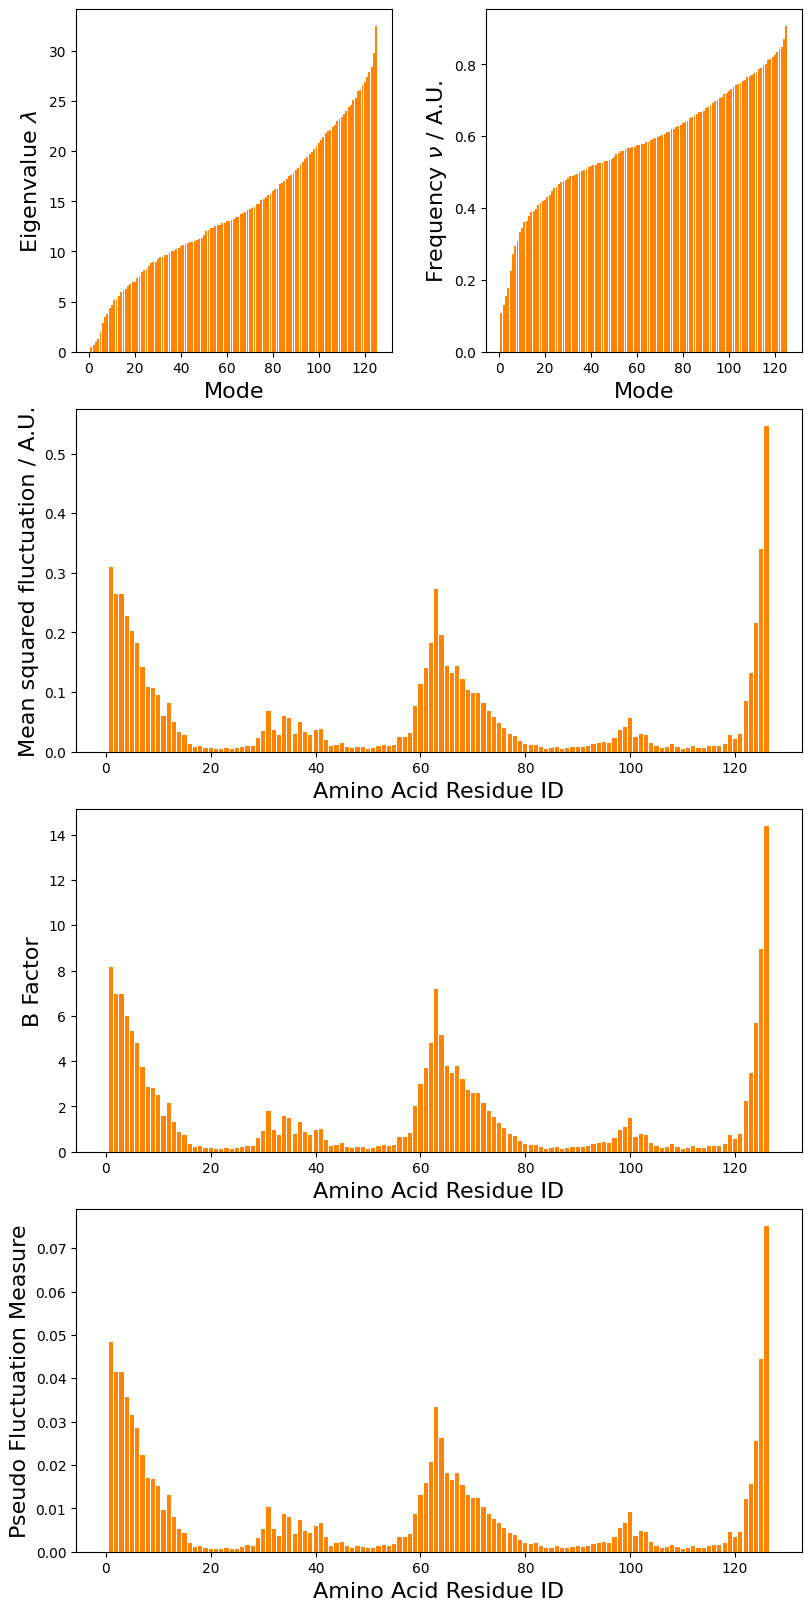

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import springcraft

gnm = calculate_normal_modes_gnm_from_id("1A0A", 10.0)
eigenval, eigenvec = gnm.eigen() 

pseudo_fluc = pseudo_fluctuation_measure(eigenval, eigenvec, 10, lambda x: 1/x)
msqf = gnm.mean_square_fluctuation(mode_subset = np.array([i for i in range(1, 10)]))
bfact = gnm.bfactor(mode_subset = np.array([i for i in range(1, 10)]))
freq = gnm.frequencies()[1:]

eigenval = eigenval[1:]
fig = plt.figure(figsize=(8.0, 16.0), constrained_layout=True)
grid = fig.add_gridspec(nrows=4, ncols=2)

ax00 = fig.add_subplot(grid[0, 0])
ax01 = fig.add_subplot(grid[0, 1])
ax1 = fig.add_subplot(grid[1, :])
ax2 = fig.add_subplot(grid[2, :])
ax3 = fig.add_subplot(grid[3, :])

biotite_c = biotite.colors["orange"]

ax00.bar(x=np.arange(1, len(eigenval)+1), height=eigenval, color=biotite_c)
ax01.bar(x=np.arange(1, len(freq)+1), height=freq, color=biotite_c)
ax1.bar(x=np.arange(1, len(msqf)+1), height=msqf, color=biotite_c)
ax2.bar(x=np.arange(1, len(bfact)+1), height=bfact, color=biotite_c)
ax3.bar(x=np.arange(1, len(pseudo_fluc)+1), height=pseudo_fluc, color=biotite_c)

ax00.set_xlabel("Mode", size=16)
ax00.set_ylabel(r"Eigenvalue $\lambda$", size=16)
ax01.set_xlabel("Mode", size=16)
ax01.set_ylabel(r"Frequency $\nu$ / A.U.", size=16)
ax1.set_xlabel("Amino Acid Residue ID", size=16)
ax1.set_ylabel("Mean squared fluctuation / A.U.", size=16)
ax2.set_xlabel("Amino Acid Residue ID", size=16)
ax2.set_ylabel("B Factor", size=16)
ax3.set_xlabel("Amino Acid Residue ID", size=16)
ax3.set_ylabel("Pseudo Fluctuation Measure", size=16)

plt.show()

## Data Preparation for Training Phase

In [1]:
from typing import Literal
import math

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_cluster
import torch_geometric
from atom3d.util.formats import bp_to_df, read_any
from Bio.Data.IUPACData import protein_letters_3to1

import biotite
import biotite.structure as struc
import biotite.structure.io as strucio
import springcraft

STANDARD_AMINO_ACIDS = ["ALA", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN", "ARG", "SER", "THR", "VAL", "TRP", "TYR", "PYL", "SEC" \
                        "XLE", "GLX", "XAA", "ASX"]

_aa_alphabet = {aa: i for i, aa in enumerate(STANDARD_AMINO_ACIDS)}


class DataPreProcessor():
    """
    This calss is in the top of the hierarchy. It will be used to load data.
    There are two child classes, depending on the method that is used in the
    training phase.
    """
    def __init__(
        self,
        node_alphabet: dict[str, int],
        edge_cutoff: float = 4.5,
        num_rbf: int = 16,
        self_loop: bool = False,
        device: str = "cpu",
        dtype=torch.float32,
    ):
        self.node_alphabet = node_alphabet
        self.edge_cutoff = edge_cutoff
        self.device = device
        self.dtype = dtype
        self.self_loop = self_loop
        self.num_rbf = num_rbf
        # TODO: Allow various radial functions

    def from_file(self, file_path: str, **kwargs) -> torch_geometric.data.Data:
        """
        Read a protein from a file and return a graph representation.

        Args:
            file_path (str): Path to the file to read.
            **kwargs: Additional arguments to pass to `__call__`.

        Returns:
            torch_geometric.data.Data: Graph representation of the protein.
        """

        whole_structure = strucio.load_structure(file_path)
        protein = whole_structure[struc.filter_amino_acids(whole_structure)]
        label = 0
        return self(protein, label, **kwargs)

    def from_loaded_structure(self, structure: struc.AtomArray, label: int, **kwargs):
        return self(structure, label, **kwargs)

class DataPreProcessorForANM(DataPreProcessor):
    """
    This calss is a pre-processor for extension part of the project, where
    vector features are going to be used for predicting results.
    """
    pass

class DataPreProcessorForGNM(DataPreProcessor):
    """
    This calss is a pre-processor for the core of the project being use of 
    flexibility value that does not depend on the 
    """
    def __init__(
        self,
        node_alphabet: dict[str, int] = _aa_alphabet,
        edge_cutoff: float = 10.0,
        n_pos_embeddings: int = 16,
        type_flexibility: Literal["msqf", "bfactor", "pseudo", "none"] = "none",
        num_classes: int = 384,
        **kwargs,
    ):
        super().__init__(node_alphabet, edge_cutoff, **kwargs)
        self.n_pos_embeddings = n_pos_embeddings
        self.type_flexibility = type_flexibility
        self.num_classes = num_classes

    def __call__(self, protein: struc.AtomArray, label: int) -> torch_geometric.data.Data:
        
        # Creating DataFrame, as it is easier to operate on
        df = pd.DataFrame(protein.coord, columns=['x', 'y', 'z'])
        df["chain"] = protein.chain_id
        df["residue"] = protein.res_id
        df["name"] = protein.atom_name
        df["resname"] = protein.res_name
        
        # Get nodes
        coords = torch.as_tensor(self._get_residue_coords(df), device=self.device, dtype=self.dtype)
        node_types = torch.as_tensor(
            self._get_residue_types(df), dtype=torch.long, device=self.device
        )
        mask = torch.isfinite(coords.sum(axis=1))
        coords[~mask] = np.inf

        # Get edges
        edge_index = torch_cluster.radius_graph(coords, r=self.edge_cutoff, loop=self.self_loop)

        # Add node features
        dihedrals = self._dihedrals(df)
        orientations = self._orientations(coords)
        sidechains = self._sidechains(df)
        if self.type_flexibility == "none":
            node_s = dihedrals
            node_v = torch.cat([orientations, sidechains.unsqueeze(-2)], dim=-2)
        else:
            flexibility = self._flexibility(protein, self.edge_cutoff, 10)
            node_s = torch.cat([dihedrals, flexibility], dim=-1)
            node_v = torch.cat([orientations, sidechains.unsqueeze(-2)], dim=-2)

        # Add edge features
        pos_embeddings = self._positional_embeddings(edge_index)
        E_vectors = coords[edge_index[0]] - coords[edge_index[1]]
        rbf = _rbf(E_vectors.norm(dim=-1), D_count=self.num_rbf, device=self.device)
        edge_s = torch.cat([rbf, pos_embeddings], dim=-1)
        edge_v = _normalize(E_vectors).unsqueeze(-2)

        # Turn NaN to zeros
        node_s, node_v, edge_s, edge_v = map(torch.nan_to_num, (node_s, node_v, edge_s, edge_v))

        prob = np.zeros(self.num_classes)
        prob[label] = 1

        return torch_geometric.data.Data(
            x=coords,
            y=torch.as_tensor(prob, device=self.device, dtype=self.dtype),
            node_type=node_types,
            edge_index=edge_index,
            node_s=node_s,
            node_v=node_v,
            edge_s=edge_s,
            edge_v=edge_v,
            mask=mask,
        )
        
    def _get_residue_coords(self, df: pd.DataFrame) -> np.ndarray:
        return df[df["name"] == "CA"][["x", "y", "z"]].to_numpy()

    def _get_residue_types(self, df: pd.DataFrame) -> np.ndarray:
        return df[df["name"] == "CA"]["resname"].map(self.node_alphabet).to_numpy()

    def _dihedrals(self, df: pd.DataFrame, eps: float = 1e-7) -> torch.Tensor:
        # From https://github.com/jingraham/neurips19-graph-protein-design
        X = torch.as_tensor(
            df[df["name"].isin(["N", "CA", "C", "O"])][["x", "y", "z"]].values.reshape(-1, 4, 3)
        )

        X = torch.reshape(X[:, :3], [3 * X.shape[0], 3])
        dX = X[1:] - X[:-1]
        U = _normalize(dX, dim=-1)
        u_2 = U[:-2]
        u_1 = U[1:-1]
        u_0 = U[2:]

        # Backbone normals
        n_2 = _normalize(torch.cross(u_2, u_1), dim=-1)
        n_1 = _normalize(torch.cross(u_1, u_0), dim=-1)

        # Angle between normals
        cosD = torch.sum(n_2 * n_1, -1)
        cosD = torch.clamp(cosD, -1 + eps, 1 - eps)
        D = torch.sign(torch.sum(u_2 * n_1, -1)) * torch.acos(cosD)

        # This scheme will remove phi[0], psi[-1], omega[-1]
        D = F.pad(D, [1, 2])
        D = torch.reshape(D, [-1, 3])
        # Lift angle representations to the circle
        D_features = torch.cat([torch.cos(D), torch.sin(D)], 1)
        return D_features

    def _positional_embeddings(self, edge_index: torch.Tensor) -> torch.Tensor:
        # From https://github.com/jingraham/neurips19-graph-protein-design
        d = edge_index[0] - edge_index[1]

        frequency = torch.exp(
            torch.arange(0, self.n_pos_embeddings, 2, dtype=self.dtype, device=self.device)
            * -(np.log(10000.0) / self.n_pos_embeddings)
        )
        angles = d.unsqueeze(-1) * frequency
        E = torch.cat((torch.cos(angles), torch.sin(angles)), -1)
        return E

    def _orientations(self, X: torch.Tensor) -> torch.Tensor:
        forward = _normalize(X[1:] - X[:-1])
        backward = _normalize(X[:-1] - X[1:])
        forward = F.pad(forward, [0, 0, 0, 1])
        backward = F.pad(backward, [0, 0, 1, 0])
        return torch.cat([forward.unsqueeze(-2), backward.unsqueeze(-2)], -2)

    def _sidechains(self, df: pd.DataFrame) -> torch.Tensor:
        # For each structure, X should be a num_residues x 4 x 3 nested
        # list of the positions of the backbone N, C-alpha, C, and O atoms of
        # each residue (in that order).
        X = torch.as_tensor(
            df[df["name"].isin(["N", "CA", "C", "O"])][["x", "y", "z"]].values.reshape(-1, 4, 3)
        )
        n, origin, c = X[:, 0], X[:, 1], X[:, 2]
        c, n = _normalize(c - origin), _normalize(n - origin)
        bisector = _normalize(c + n)
        perp = _normalize(torch.cross(c, n))
        vec = -bisector * math.sqrt(1 / 3) - perp * math.sqrt(2 / 3)
        return vec
    
    def _flexibility(self, protein: struc.AtomArray, cutoff: float, num_modes: int):
        # Filter CA atoms only
        ca = protein[(protein.atom_name == "CA") & (protein.element == "C")]
    
        # Define force field and GNM object
        ff = springcraft.InvariantForceField(cutoff_distance= cutoff)
        gnm = springcraft.GNM(ca, ff)

        if self.type_flexibility == "pseudo":
            eigenval, eigenvec = gnm.eigen()
            pseudo_fluc = pseudo_fluctuation_measure(eigenval, eigenvec, num_modes, lambda x: 1/x)
            pseudo_fluc = torch.reshape(pseudo_fluc, [-1, 1])
            return pseudo_fluc
        elif self.type_flexibility == "msqf":
            msqf = torch.from_numpy(gnm.mean_square_fluctuation(mode_subset = np.array([i for i in range(1, num_modes+1)])))
            msqf = torch.reshape(msqf, [-1, 1])
            return msqf
        else:
            bfact = torch.from_numpy(gnm.bfactor(mode_subset = np.array([i for i in range(1, num_modes+1)])))
            bfact = torch.reshape(bfact, [-1, 1])
            return bfact 

def _normalize(tensor: torch.Tensor, dim: int = -1) -> torch.Tensor:
    """
    Normalizes a `torch.Tensor` along dimension `dim` without `nan`s.
    """
    return torch.nan_to_num(torch.div(tensor, torch.norm(tensor, dim=dim, keepdim=True)))

def _rbf(
    D: torch.Tensor, D_min: float = 0.0, D_max: float = 20.0, D_count: int = 16, device: str = "cpu"
) -> torch.Tensor:
    """
    From https://github.com/jingraham/neurips19-graph-protein-design

    Returns an RBF embedding of `torch.Tensor` `D` along a new axis=-1.
    That is, if `D` has shape [...dims], then the returned tensor will have
    shape [...dims, D_count].
    """
    D_mu = torch.linspace(D_min, D_max, D_count, device=device)
    D_mu = D_mu.view([1, -1])
    D_sigma = (D_max - D_min) / D_count
    D_expand = torch.unsqueeze(D, -1)

    RBF = torch.exp(-(((D_expand - D_mu) / D_sigma) ** 2))
    return RBF

In [2]:
x = DataPreProcessorForGNM(type_flexibility = "msqf")
x.from_file("./data/1aar.pdb")

Data(x=[152, 3], edge_index=[2, 2486], y=[384], node_type=[152], node_s=[152, 7], node_v=[152, 3, 3], edge_s=[2486, 32], edge_v=[2486, 1, 3], mask=[152])

### Loading Data

In [3]:
%pip install loguru


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\Mihailo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
from libraries.lmdb_dataset import LMDBDataset

database = LMDBDataset("./data/pdb_data")
database

LMDBDataset(c:\Users\Mihailo\Desktop\Cambridge Part II\Part II Project\Part-II-Project-Protein-Dynamics-and-Flexibility\data\pdb_data)
	name:          pdb_data
	num_examples:  17,550
	size_on_disk:  2,104.70 MB

In [4]:
# To look at metadata

database.metadata.head()

,resolution,n_atoms,n_bonds,n_chains,n_models,r_free,r_work,deposition_date,release_date,method
2p0w,1.90,6410,5769,16,1,0.228,0.182,2007-03-01,2007-03-13,x-ray diffraction
1ogj,1.64,2750,2456,4,1,0.228,0.207,2003-05-06,2003-09-25,x-ray diffraction
1wc0,2.40,3247,3157,8,1,0.271,0.219,2004-11-05,2004-12-20,x-ray diffraction
2kzr,NaN,26620,26760,20,20,NaN,NaN,2010-06-23,2010-07-07,solution nmr
1gv1,2.50,9395,9059,8,1,0.305,0.216,2002-02-04,2002-02-20,x-ray diffraction


In [5]:
# You can access file like this
# by id:
database["5i4n"]
# via index:
database[0]

{'id': '2p0w',
 'structure': array([
 	Atom(np.array([125.653, -15.264,   3.862], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="N", element="N"),
 	Atom(np.array([124.756, -14.367,   4.653], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="CA", element="C"),
 	Atom(np.array([123.415, -14.216,   3.936], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="C", element="C"),
 	Atom(np.array([122.351, -14.145,   4.572], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="O", element="O"),
 	Atom(np.array([125.415, -13.004,   4.872], dtype=float32), chain_id="A", res_id=23, ins_code="", res_name="ALA", hetero=False, atom_name="CB", element="C"),
 	Atom(np.array([123.481, -14.171,   2.607], dtype=float32), chain_id="A", res_id=24, ins_code="", res_name="GLU", hetero=False, atom_name="N", element="N"),
 	Atom(np.arr

In [6]:
import biotite.structure as struc
# To get specific chain, e.g. chain 'A', use
structure = database["5i4n"]["structure"]
protein_chain = structure[(structure.chain_id == "A") & struc.filter_amino_acids(structure)] 
protein_chain

array([
	Atom(np.array([-18.451,   0.162,  21.106], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="N", element="N"),
	Atom(np.array([-17.658,   0.39 ,  19.899], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-17.917,   1.767,  19.301], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="C", element="C"),
	Atom(np.array([-19.058,   2.236,  19.271], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="O", element="O"),
	Atom(np.array([-17.982,  -0.654,  18.823], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="CB", element="C"),
	Atom(np.array([-17.147,  -1.902,  18.894], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="CG", element="C"),
	Atom(np.array([-15.77 ,  -1.836,  18.99 

In [7]:
# To get c_alpha atoms of the protein backbone use
protein_backbone = protein_chain[(protein_chain.atom_name == "CA")]
protein_backbone

array([
	Atom(np.array([-17.658,   0.39 ,  19.899], dtype=float32), chain_id="A", res_id=537, ins_code="", res_name="PHE", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-16.908,   3.658,  18.091], dtype=float32), chain_id="A", res_id=538, ins_code="", res_name="HIS", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-19.519,   4.237,  15.382], dtype=float32), chain_id="A", res_id=539, ins_code="", res_name="LYS", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-18.046,   4.709,  11.938], dtype=float32), chain_id="A", res_id=540, ins_code="", res_name="ILE", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-19.983,   6.463,   9.169], dtype=float32), chain_id="A", res_id=541, ins_code="", res_name="ARG", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-20.873,   4.278,   6.202], dtype=float32), chain_id="A", res_id=542, ins_code="", res_name="ASN", hetero=False, atom_name="CA", element="C"),
	Atom(np.array([-19.708,   7.025,   3.

In [9]:
import pandas as pd

labels = pd.read_csv("./data/enzyme_data/chain_functions.txt", names = ["chain_id", "label"])
labels[['id', 'chain']] = labels['chain_id'].str.split('.', 1, expand=True)
(labels["label"]==384).unique()


C:\Users\Mihailo\AppData\Local\Temp\ipykernel_13964\1125711676.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  labels[['id', 'chain']] = labels['chain_id'].str.split('.', 1, expand=True)


array([False])

In [10]:
x = DataPreProcessorForGNM(type_flexibility = "msqf")
x.from_loaded_structure(protein_chain, labels[(labels["id"] == "5i4n") & (labels["chain"] == "A")].label.iloc[0])

Data(x=[275, 3], edge_index=[2, 4864], y=[384], node_type=[275], node_s=[275, 7], node_v=[275, 3, 3], edge_s=[4864, 32], edge_v=[4864, 1, 3], mask=[275])

In [12]:
training_set = set(line.strip() for line in open('./data/enzyme_data/training.txt')).difference(set(line.strip().replace("_",".") for line in open('./data/enzyme_data/missing_resis.txt')))
testing_set = set(line.strip() for line in open('./data/enzyme_data/testing.txt')).difference(set(line.strip().replace("_",".") for line in open('./data/enzyme_data/missing_resis.txt')))
validating_set = set(line.strip() for line in open('./data/enzyme_data/validation.txt')).difference(set(line.strip().replace("_",".") for line in open('./data/enzyme_data/missing_resis.txt')))

In [13]:
def check_chain(chain: biotite.structure.AtomArray):
    ns = chain[chain.atom_name == 'N']
    cas = chain[chain.atom_name == 'CA']
    cs = chain[chain.atom_name == 'C']
    os = chain[chain.atom_name == 'O']
    if not (set(chain.res_name).issubset(set(STANDARD_AMINO_ACIDS))):
        return False
    if(np.array_equal(ns.res_id, cas.res_id) and np.array_equal(cas.res_id, cs.res_id) and np.array_equal(cs.res_id, os.res_id)):
        return True
    return False

In [15]:
%pip install progressbar


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\Mihailo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
from progressbar import ProgressBar
pbar = ProgressBar()


training_structures = []
for id in pbar(training_set):
    PDBid, chain = id.split(".")
    x = DataPreProcessorForGNM(type_flexibility = "msqf")
    if(database.__contains__(PDBid)):
        structure = database[PDBid]["structure"]
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            training_structures.append(x.from_loaded_structure(protein_chain, labels[(labels["id"] == PDBid) & (labels["chain"] == chain)].label.iloc[0]))

In [ ]:
from progressbar import ProgressBar
pbar = ProgressBar()

testing_structures = []
for id in pbar(testing_set):
    PDBid, chain = id.split(".")
    x = DataPreProcessorForGNM(type_flexibility = "msqf")
    if(database.__contains__(PDBid)):
        structure = database[PDBid]["structure"]
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            testing_structures.append(x.from_loaded_structure(protein_chain, labels[(labels["id"] == PDBid) & (labels["chain"] == chain)].label.iloc[0]))

In [ ]:
pbar = ProgressBar()

validating_structures = []
for id in pbar(validating_set):
    PDBid, chain = id.split(".")
    x = DataPreProcessorForGNM(type_flexibility = "msqf")
    if(database.__contains__(PDBid)):
        structure = database[PDBid]["structure"]
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            validating_structures.append(x.from_loaded_structure(protein_chain, labels[(labels["id"] == PDBid) & (labels["chain"] == chain)].label.iloc[0]))

In [ ]:
print(len(training_structures))
print(len(testing_structures))
print(len(validating_structures))

In [ ]:
pbar = ProgressBar()

all_structures = []
for id in pbar(set(labels.chain_id).difference(set(line.strip().replace("_",".") for line in open('missing_resis.txt')))):
    PDBid, chain = id.split(".")
    x = DataPreProcessorForGNM(type_flexibility = "msqf")
    if(database.__contains__(PDBid)):
        structure = database[PDBid]["structure"]
        protein_chain = structure[(structure.chain_id == chain) & struc.filter_amino_acids(structure)] 
        if(check_chain(protein_chain)):
            validating_structures.append(x.from_loaded_structure(protein_chain, labels[labels.chain_id == id].label.iloc[0]))

In [ ]:
len(all_structures)

In [ ]:
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

In [ ]:
def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)

In [ ]:
train_loader = DataLoader(validating_structures[:1], batch_size=2, shuffle=True)
val_loader = DataLoader(validating_structures, batch_size=2, shuffle=False)
test_loader = DataLoader(testing_structures, batch_size=2, shuffle=False)

In [ ]:
training_structures[0].edge_s.type()

In [ ]:
class EquivariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=32, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is invariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # ============ YOUR CODE HERE ==============
        # MLP `\psi` for computing messages `m_ij`
        # dims: (2d + d_e + 1) -> d
        self.mlp_msg = self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )  
        # MLP `\psi`
        self.mlp_upd_features = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        self.mlp_upd_coord = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, 1), BatchNorm1d(1), ReLU()
          )

    def forward(self, h, pos, edge_index, edge_s):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        # ============ YOUR CODE HERE ==============
        # Notice that the `forward()` function has a new argument 
        # `pos` denoting the initial node coordinates. Your task is
        # to update the `propagate()` function in order to pass `pos`
        # to the `message()` function along with the other arguments.
        
        out = self.propagate(edge_index, h=h, edge_s=edge_s, pos=pos)
        return out
        # ==========================================

    # ============ YOUR CODE HERE ==============
    # Write a custom `message()` function that takes as arguments the
    # source and destination node features, node coordiantes, and `edge_attr`.
    # Incorporate the coordinates `pos` into the message computation such
    # that the messages are invariant to rotations and translations.
    # This will ensure that the overall layer is also invariant.
    #
    def message(self, h_i, h_j, pos_i, pos_j, edge_s):
      """The `message()` function constructs messages from source nodes j 
       to destination nodes i for each edge (i, j) in `edge_index`.
    
       Args:
           h_i: (e, d) - destination node features
           h_j: (e, d) - source node features
           pos_i: (e, 3) - destination node coordinates
           pos_j: (e, 3) - source node coordinates
           edge_attr: (e, d_e) - edge features
        
       Returns:
           msg: (e, d) - messages `m_ij` passed through MLP `\psi`
      """ 
      msg = torch.concat([h_i, h_j, (pos_i-pos_j).norm(dim=1, p=2).reshape(-1,1), edge_s], dim=-1)
      return (self.mlp_msg(msg), self.mlp_upd_coord(msg)*(pos_i-pos_j))
    # ==========================================
    
    def aggregate(self, inputs, index, pos_i, pos_j):
        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        inputs_x, inputs_coord = inputs
        return (scatter(inputs_x, index, dim=self.node_dim, reduce=self.aggr),\
                scatter(inputs_coord, index, dim=self.node_dim, reduce=self.aggr))
    #
    def update(self, aggr_out, h, pos):
      """The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
      """
      upd_out_features = torch.cat([h, aggr_out[0]], dim=-1)
      return (self.mlp_upd_features(upd_out_features),pos+aggr_out[1])

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class EGNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=8, edge_dim=32, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations.

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of invariant MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(EquivariantMPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(torch.cat((data.node_s.to(torch.float32),data.node_type.reshape(-1,1).to(torch.float32)), dim=1)) # (n, d_n) -> (n, d)
        pos = data.x

        for conv in self.convs:
            h, pos = conv(h, pos, data.edge_index, data.edge_s) # (n, d) -> (n, d)

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = F.softmax(self.lin_pred(h_graph), dim=1) # (batch_size, d) -> (batch_size, 384)

        return out.view(-1)

In [ ]:
def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (torch.argmax(y_pred) != torch.argmax(data.y)).sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        
        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))
    
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

In [ ]:
model = EGNNModel(num_layers=4, emb_dim=64, in_dim=8, edge_dim=32, out_dim=384)
model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)
(best_val_error, test_error, train_time)